In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt


import os, sys, argparse

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import Perceptron



# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [2]:

def get_loss_function(perceptron, ts, H_obj, dev):

    @jax.jit
    @qml.qnode(dev, interface="jax")
    def loss(param_vector):

        # hamitlonian_params = dictionary_to_hamiltonian_parameters(params_dict)

        param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

        qml.evolve(perceptron.H)(param_list, ts)

        return qml.expval(H_obj)

    return loss


In [4]:

# setting up the problem
perceptron_qubits = 8
pulse_basis = 5
ts = jnp.array([0.0, 1.0])

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron = Perceptron(perceptron_qubits, pulse_basis, basis='gaussian', pulse_width=0.05)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
print(f'Exact ground state energy: {e_ground_state_exact}')


Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (0.1) [X4]
+ (0.1) [X5]
+ (0.1) [X6]
+ (0.1) [X7]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]
+ (1.0) [Z3 Z4]
+ (1.0) [Z4 Z5]
+ (1.0) [Z5 Z6]
+ (1.0) [Z6 Z7]
Exact ground state energy: -7.025018814832985


In [5]:
# getting the loss_function
loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(0)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [5.27317155e-02 3.78871223e-01 1.06604464e-01 6.81408787e-01
 7.94926262e-01 4.26091811e-01 7.57560236e-01 9.08531097e-01
 5.19441697e-01 6.95296533e-01 9.32729983e-01 4.23380738e-01
 1.72747743e-01 3.37123433e-01 4.73911998e-01 2.67048165e-01
 2.04933276e-01 7.72032056e-02 1.00272119e-01 6.53860749e-01
 1.30763936e-01 8.02537726e-01 8.70525651e-01 8.94636895e-01
 8.19288518e-01 4.72266513e-01 1.00364845e-01 2.56509671e-01
 3.82071855e-01 4.82656132e-01 9.27004920e-01 8.13294487e-01
 9.90745008e-01 7.88266864e-01 9.17642550e-01 6.11803283e-01
 3.69418706e-01 5.59330155e-01 4.79103984e-01 9.26080443e-01
 5.06613763e-01 4.49984255e-01 1.63963170e-01 6.46544986e-01
 1.43330958e-01 5.83963740e-01 8.12780222e-01 4.61074034e-01
 4.51910798e-02 7.66349547e-01 8.05416597e-01 7.25451935e-01
 7.04008077e-01 7.11236913e-01 4.89168423e-01 2.73857042e-01
 9.75639444e-01 2.89149579e-01 3.45513485e-01 5.90419837e-01
 5.62335448e-01 5.79508469e-01 4.79954090e-03 5.95718287e-02
 5.5

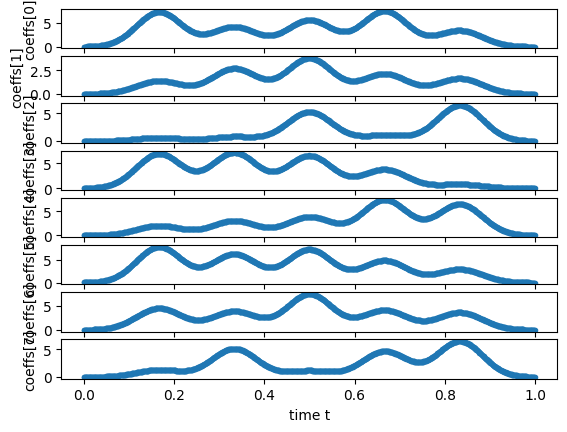

In [6]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()


In [14]:

from datetime import datetime

n_epochs = 400
param_vector = perceptron.get_random_parameter_vector(8098)


# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
schedule0 = optax.constant_schedule(1)
schedule1 = optax.constant_schedule(0.2)
schedule = optax.join_schedules([schedule0, schedule1], [50])
optimizer = optax.adam(learning_rate=schedule)
# optimizer = optax.adam(learning_rate=1)
opt_state = optimizer.init(param_vector)

energies = np.zeros(n_epochs )
# energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)

gradients_trajectory = []
param_trajectory = []

## Compile the evaluation and gradient function and report compilation time
time0 = time()
_ = value_and_grad(param_vector)
time1 = time()

# print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)

    mean_gradients[n] = np.mean(np.abs(grads))
    energies[n] = val
    param_trajectory.append(param_vector)
    gradients_trajectory.append(grads)

    param_vector = optax.apply_updates(param_vector, updates)

    # mean_gradients[n] = np.mean(np.abs(grads))
    # energy[n+1] = val

    # print(f"            param: {param_vector}")

    if not n % 10:
        print(f"{n+1} / {n_epochs}; energy discrepancy: {val-e_ground_state_exact}")
        print(f"mean grad: {mean_gradients[n]}")
        print(f'gradient norm: {jnp.linalg.norm(grads)}')
        if n>=2:
            print(f'difference of gradients: {jnp.linalg.norm(grads-gradients_trajectory[-2])}')


    # if jnp.linalg.norm(gradients_trajectory[n-1] - mean_gradients[n]) < 1e-3:

    #     break


print(f"Found ground state: {energies[-1]}")


1 / 400; energy discrepancy: 5.304694251795724
mean grad: 0.6435039927902263
gradient norm: 7.6984324950949174
11 / 400; energy discrepancy: 7.13370120300351
mean grad: 0.23580618451976304
gradient norm: 3.3316602064511702
difference of gradients: 3.7452526797362067
21 / 400; energy discrepancy: 7.61161666919197
mean grad: 0.30481875045638085
gradient norm: 4.739250010622136
difference of gradients: 7.757245359619669
31 / 400; energy discrepancy: 5.320458541767139
mean grad: 0.41504591776995675
gradient norm: 5.362846930167693
difference of gradients: 6.516525824035043
41 / 400; energy discrepancy: 3.8993497302626867
mean grad: 0.40757895140216627
gradient norm: 5.554361331103014
difference of gradients: 6.9802980991512165
51 / 400; energy discrepancy: 3.260282826157396
mean grad: 0.32022045932618215
gradient norm: 5.04376412868836
difference of gradients: 8.052072553291568
61 / 400; energy discrepancy: 2.1911147956346513
mean grad: 0.20242973413044624
gradient norm: 2.878396566825678


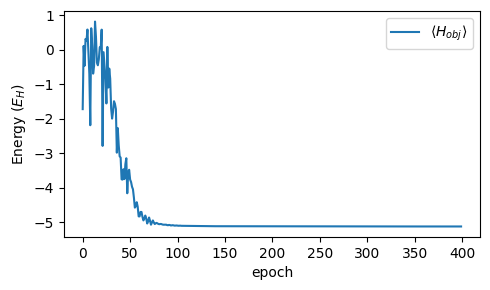

In [15]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energies 
ax.plot(y, label="$\\langle H_{{obj}}\\rangle$")
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

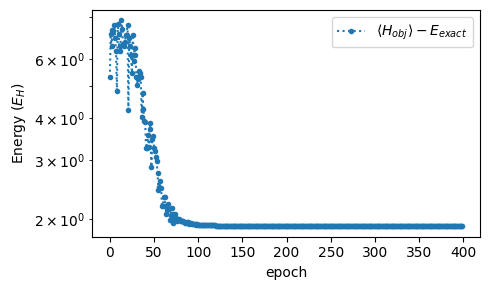

In [16]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energies - e_ground_state_exact
ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

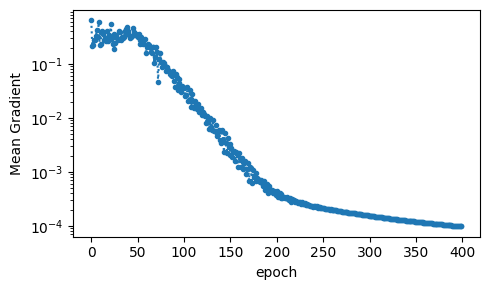

In [17]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

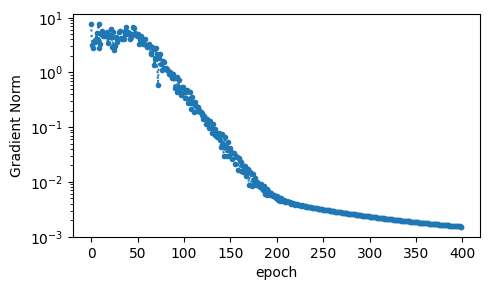

In [18]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradient) for gradient in gradients_trajectory]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Gradient Norm")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

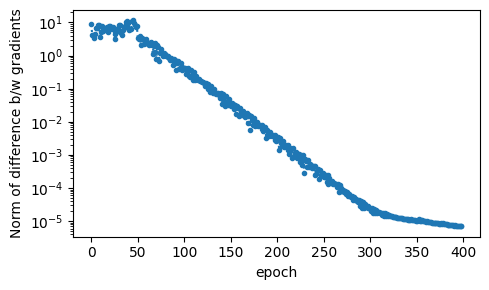

In [19]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradients_trajectory[j] - gradients_trajectory[j-1]) for j in range(1,len(gradients_trajectory))]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Norm of difference b/w gradients")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

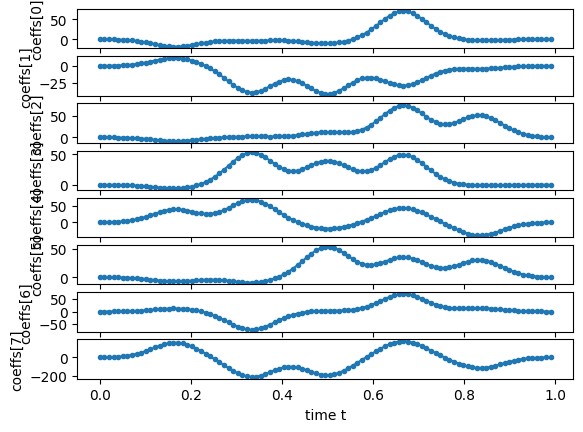

In [20]:
ts = jnp.linspace(0.0, 1, 100)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [21]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

Array([ 3.14075158e+01+0.00000000e+00j,  2.51661197e+01+0.00000000e+00j,
        2.15380501e+01+0.00000000e+00j,  1.66529912e+01+0.00000000e+00j,
        1.51514626e+01+0.00000000e+00j,  1.33480071e+01+0.00000000e+00j,
        1.06508583e+01+0.00000000e+00j,  9.13305698e+00+0.00000000e+00j,
        7.40277027e+00+0.00000000e+00j,  5.26620397e+00+0.00000000e+00j,
        4.97771034e+00+0.00000000e+00j,  4.91903990e+00+0.00000000e+00j,
        8.32700270e-01+0.00000000e+00j,  8.11341107e-01+0.00000000e+00j,
        5.08798284e-01+0.00000000e+00j,  8.48426780e-02+0.00000000e+00j,
        4.74372988e-02+0.00000000e+00j,  3.88260319e-02+0.00000000e+00j,
        3.71597041e-02+0.00000000e+00j,  1.25641211e-02+0.00000000e+00j,
        5.85452090e-03+0.00000000e+00j,  4.69569204e-03+0.00000000e+00j,
        2.79050233e-03+0.00000000e+00j,  2.08669075e-03+0.00000000e+00j,
        1.76265177e-03+0.00000000e+00j, -1.25322564e-03+0.00000000e+00j,
        1.44400623e-03+0.00000000e+00j,  1.10923230

/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


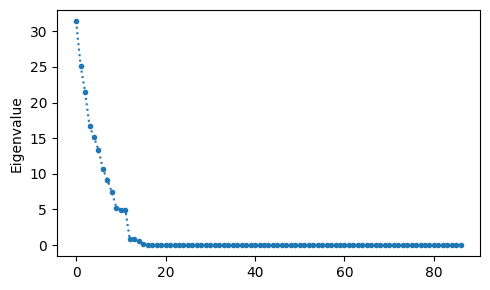

In [22]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()

plt.tight_layout()
plt.show()